In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import sklearn.metrics
from matplotlib import pyplot as plt
import seaborn as sns

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#adata=sc.read(results_file_post)
#adata.uns['log1p'] = {"base":None}

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-pac

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.5.3 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.10


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [4]:
#%matplotlib inline

In [5]:
writeDir = "write/"

fileName = "luadDost"

resultsFileQC = writeDir + fileName + '_QC.h5ad' 


In [6]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, fontsize=10, format='png')
sc.settings.figdir = "figures/" + fileName + "/"
figName = fileName

In [7]:
inDir = 'data/LUAD/GSE149655_RAW'

In [8]:
inputData1 = f'{inDir}/adeno1'
inputData2 = f'{inDir}/adeno2'


In [14]:
adata1 = sc.read_10x_mtx(inputData1, prefix="GSM4506701_Case3_ade1_",cache=True)
adata1

adata2 = sc.read_10x_mtx(inputData2, prefix="GSM4506699_Case2_ade1_",cache=True)
adata2

... reading from cache file cache/data-LUAD-GSE149655_RAW-adeno1-GSM4506701_Case3_ade1_matrix.h5ad
... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 2797 × 33538
    var: 'gene_ids', 'feature_types'

In [41]:
adata = sc.concat((adata1,adata2), label="source")
adata

AnnData object with n_obs × n_vars = 6093 × 33538
    obs: 'source'

In [42]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

In [45]:
adata

AnnData object with n_obs × n_vars = 6093 × 33538
    obs: 'source'

# Start QC
investigate highest expressed genes

normalizing counts per cell
    finished (0:00:00)


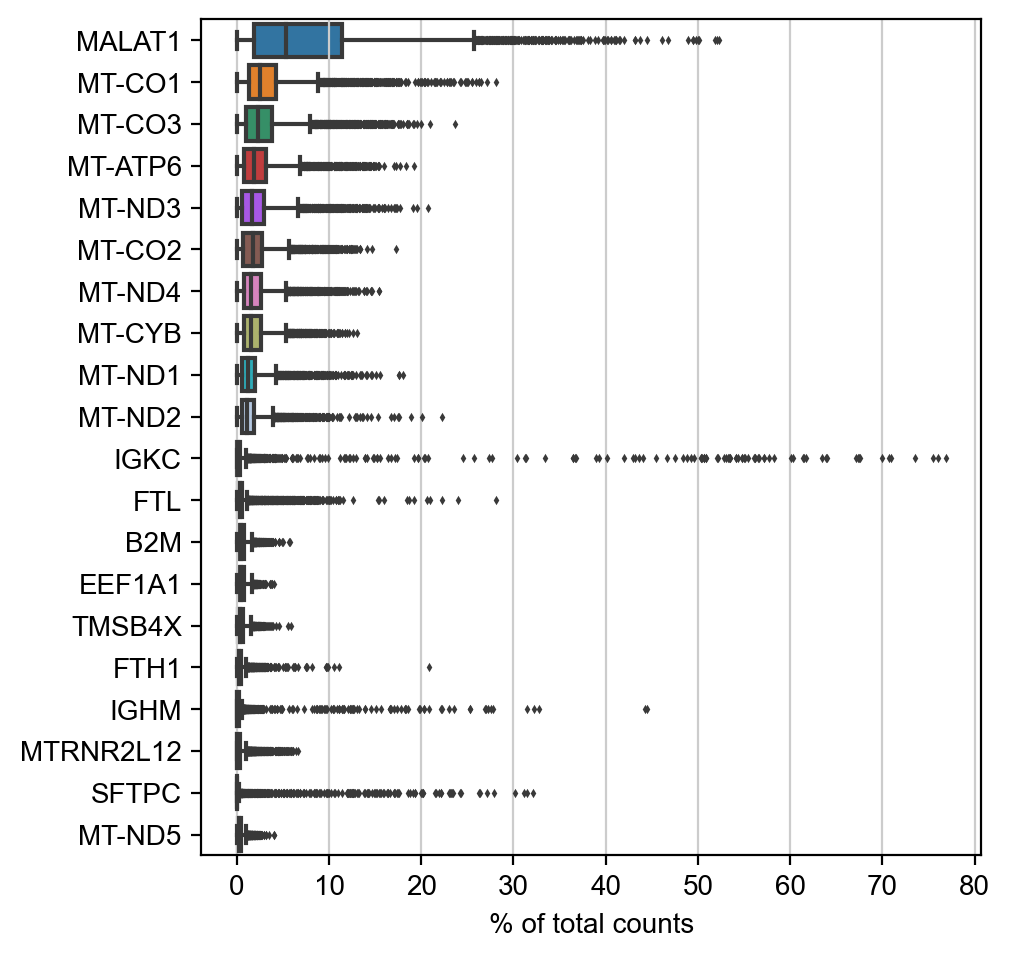

In [46]:
sc.pl.highest_expr_genes(adata, n_top=20, )

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_95760/3454098912.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


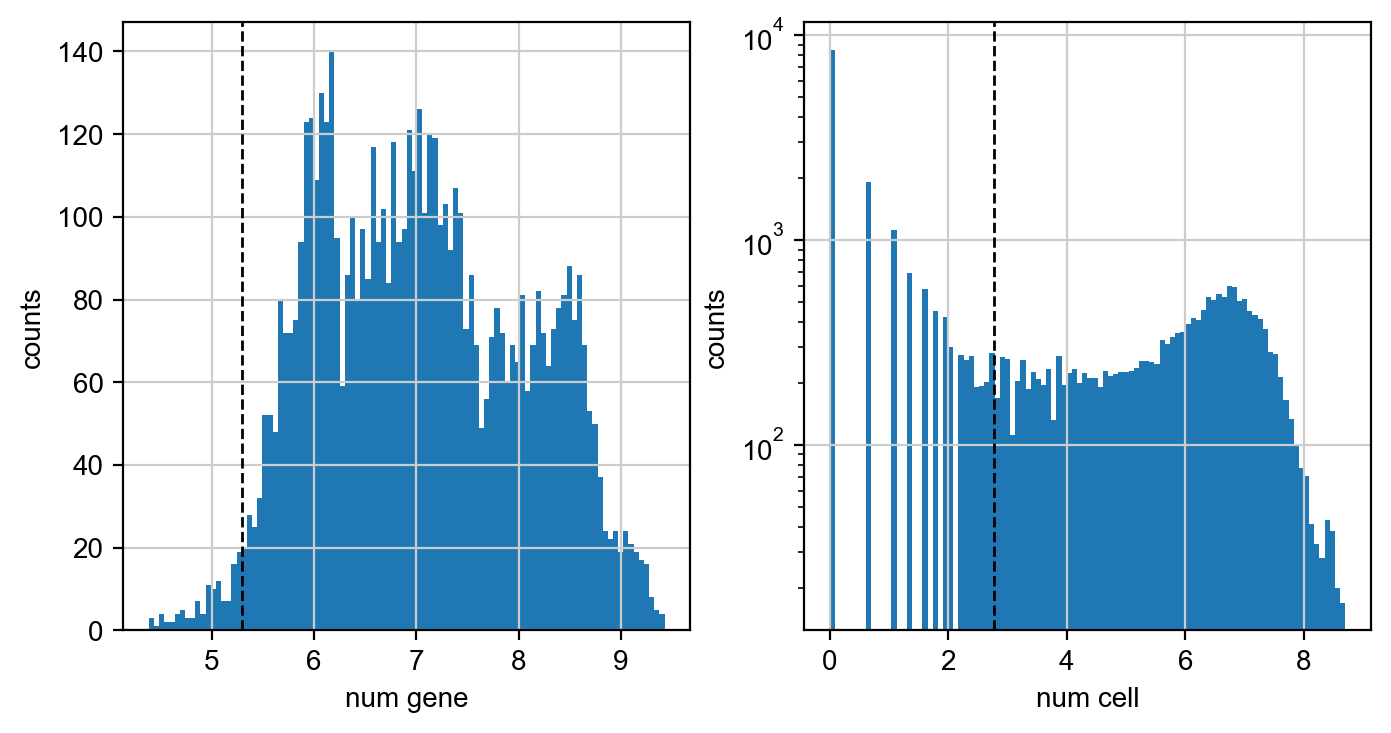

In [47]:
valX = adata.X>0
minGenes=200
minCells=15

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

numCellwExp = valX.sum(axis=1)
axs[0].hist(np.log(numCellwExp), bins=100)#, log=True)
axs[0].axvline(np.log(minGenes), color='k', linestyle='dashed', linewidth=1)
axs[0].set_xlabel('num gene')
axs[0].set_ylabel('counts')

numGeneswExp = valX.sum(axis=0).T
axs[1].hist(np.log(numGeneswExp+1), bins=100, log=True)
axs[1].axvline(np.log(minCells+1), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(600), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(4000), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].set_title('Gene means counts')
axs[1].set_xlabel('num cell')
axs[1].set_ylabel('counts')

fig.show()

In [48]:
sc.pp.filter_cells(adata, min_genes = minGenes)
sc.pp.filter_genes(adata, min_cells = minCells)

filtered out 120 cells that have less than 200 genes expressed
filtered out 15481 genes that are detected in less than 15 cells


In [49]:
adata = adata[:,np.logical_not(adata.var_names=="MALAT1")]

## Mito QC

In [50]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], log1p = False, inplace=True)

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_95760/2933791377.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')


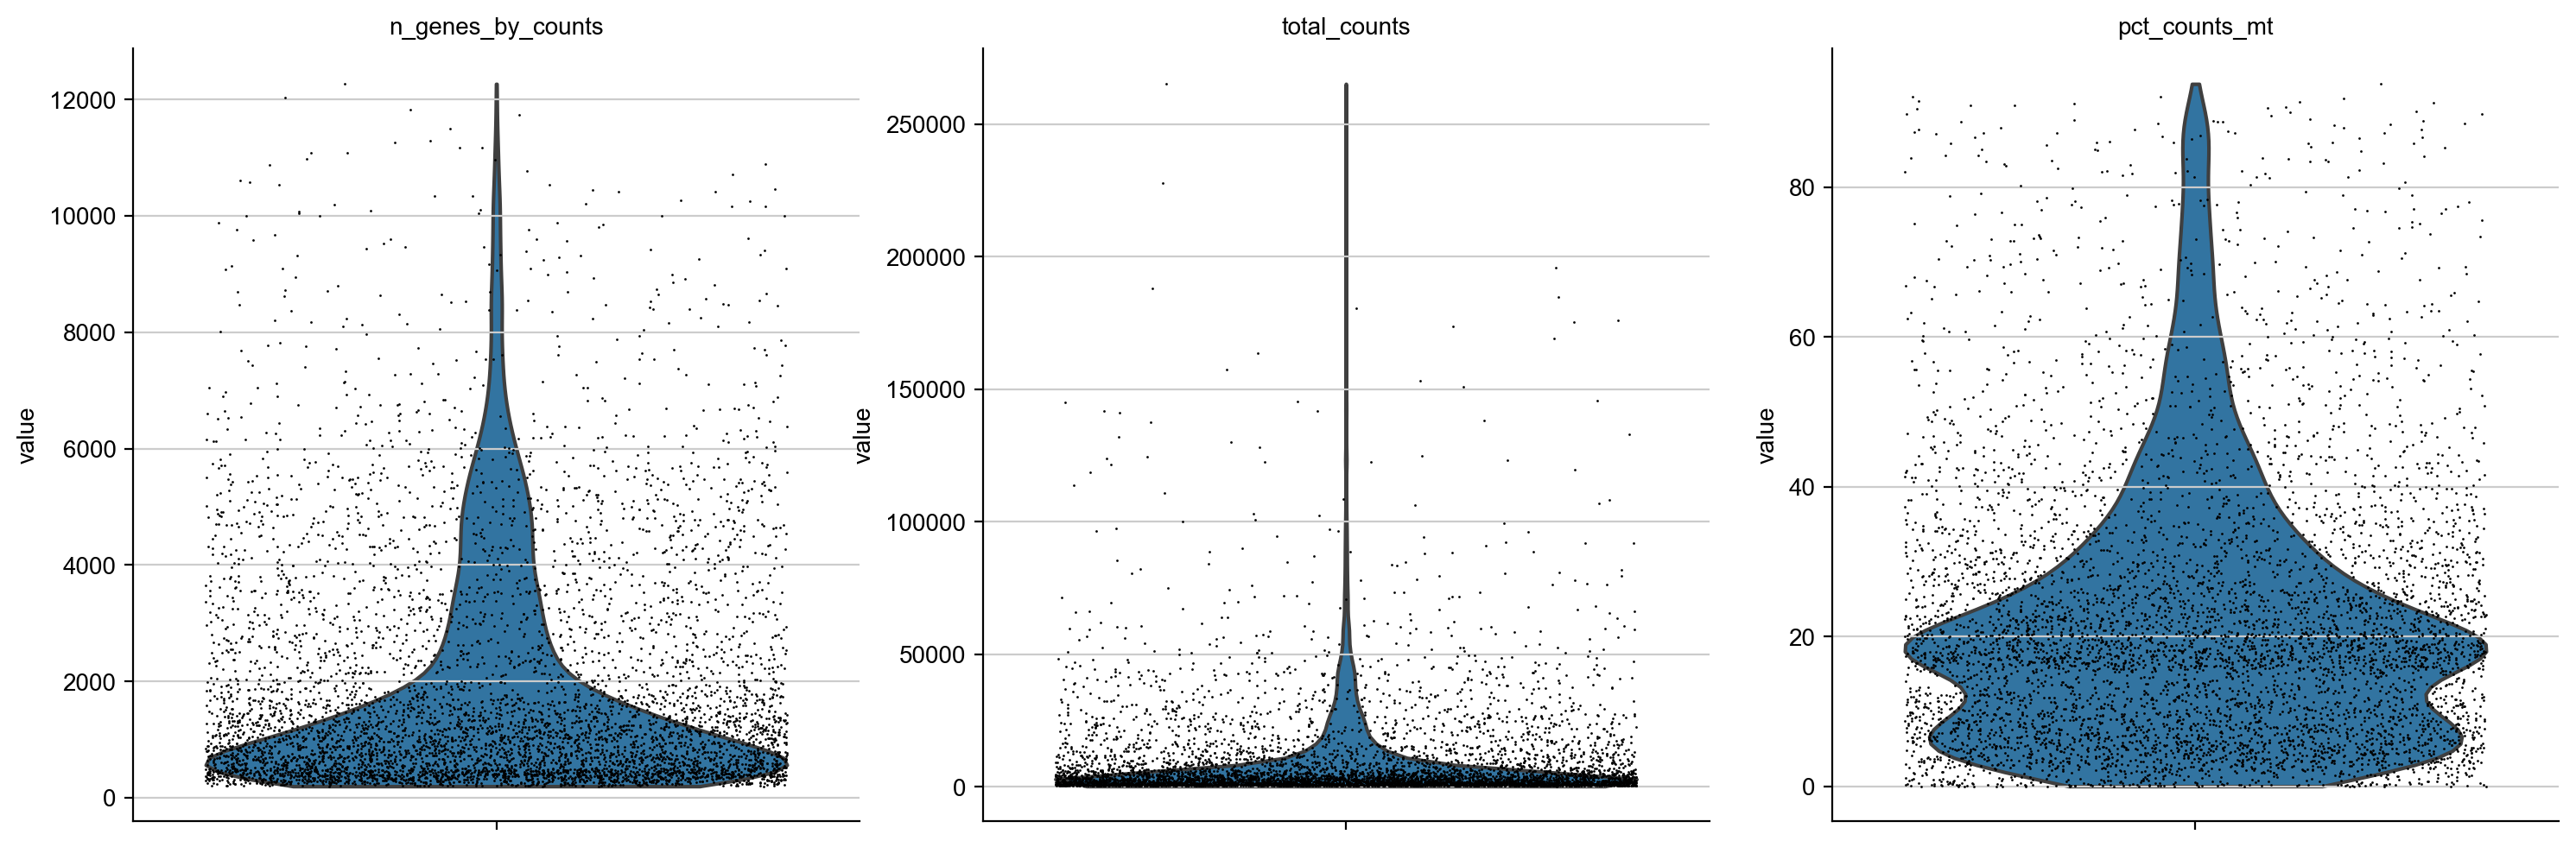

In [51]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

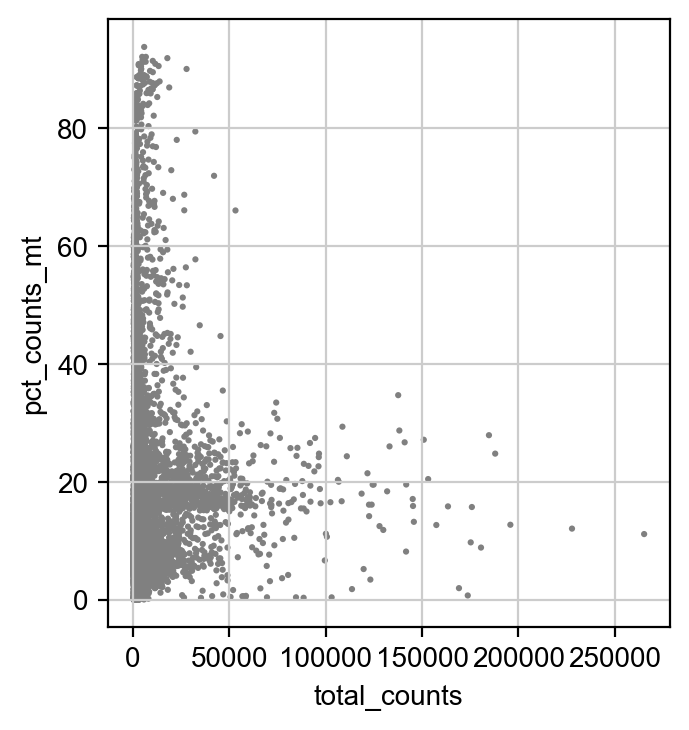

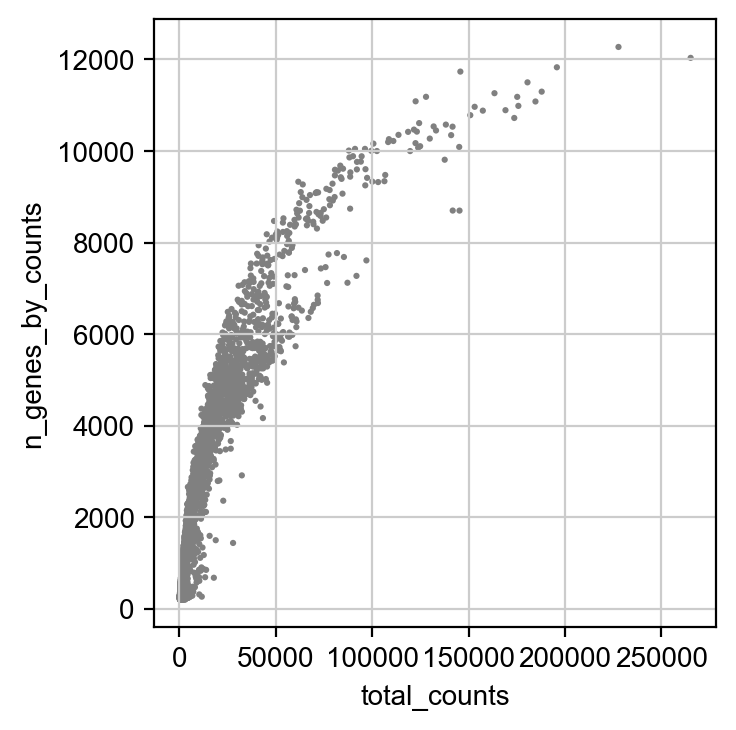

In [52]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

remove cells that have too much mito or could be doublets

In [53]:
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.total_counts < 20000, :]
adata = adata[adata.obs.pct_counts_mt < 25, :]

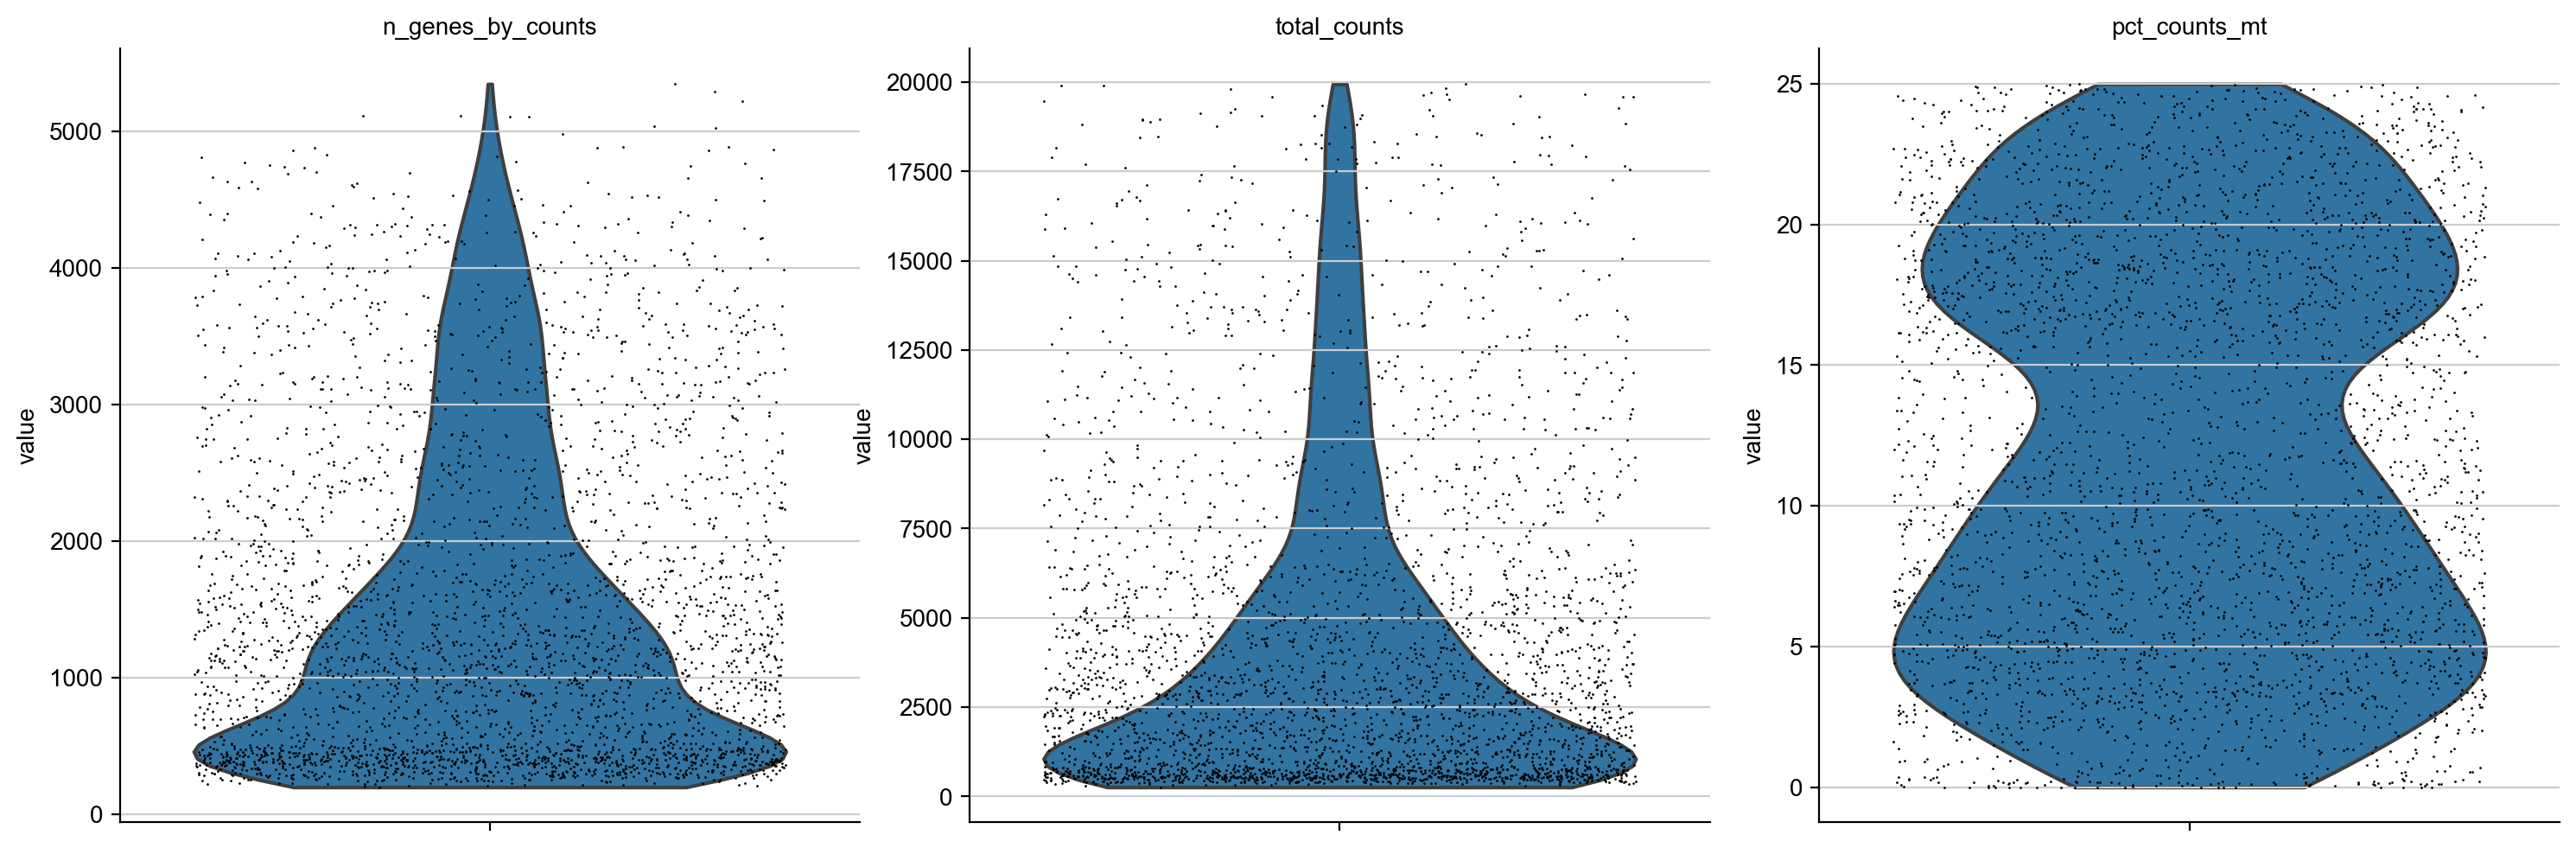

In [54]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [55]:
adata

View of AnnData object with n_obs × n_vars = 3379 × 18056
    obs: 'source', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [56]:
#adata = adata[adata.obs["injury"]=="Day 0"]
#adata

In [57]:
resultsFileQC

'write/luadDost_QC.h5ad'

In [58]:
adata.write(resultsFileQC)